In [1]:
# run IPYNB that imports all the relevant packages and functions
%run ../ms_packages_and_functions.ipynb


/home/mjms/anaconda3/envs/reach-analysis-v08/lib/python3.8/site-packages/bids/layout/validation.py:46: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


In [2]:
output_dir = pjoin(os.getcwd(), 'processed_data')
data_dir   = pjoin(os.getcwd(), 'raw_data')


In [ ]:
run_path = pjoin(output_dir,'Embeddings')

if not os.path.exists(run_path):
    os.mkdir(run_path)
    print("created directory: {}".format(run_path))
else:
    print("All files will be saved in: {}".format(run_path))

In [ ]:
fig_dir    = pjoin(run_path,'figures')
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    print("created directory: {}".format(fig_dir))
else:
    print("All figures will be saved in: {}".format(fig_dir))

# Plot Embeddings

In [5]:
all_embeddings_fp = {'RS': {'data': 'processed_data/RS_FN_UMAP_embedding.pkl'},
                    'RJ': {'data':'processed_data/RJ_FN_UMAP_embedding.pkl''}}

In [6]:
all_FN_flattened_fp = {'RS': 'processed_data/rockstar_CenterOut_FlattenedFN_wBuffer.pkl',
                    'RJ': 'processed_data/rj1031209_CenterOut_FN-Flattened_10msBin_with500buffer_MIonly-1.5-trialCount.pkl'}

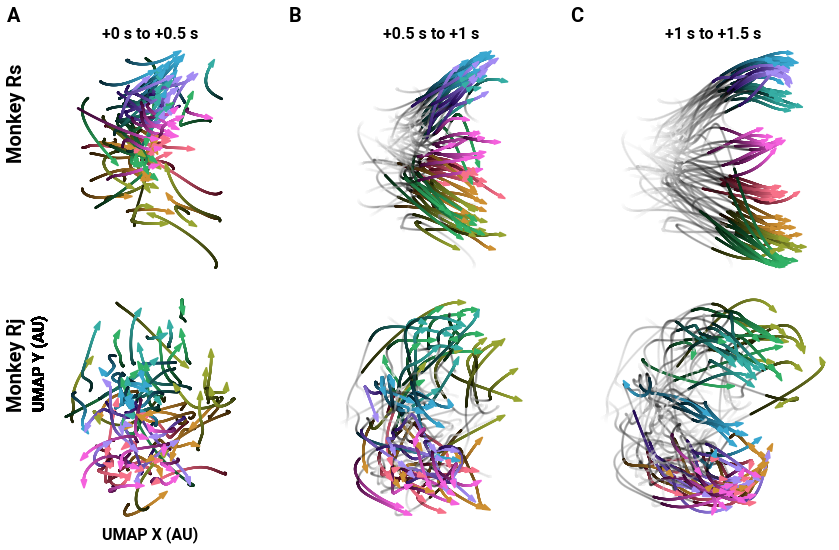

In [8]:
sns.set_context("talk")
afont = {'fontname':'Roboto','fontsize' : 16, 'ha':'center','weight':'bold'}
bfont = {'fontname':'Roboto','fontsize' : 14}
hfont = {'fontname':'Roboto','fontsize' : 20,'weight':'bold'}
cols = 3
rows = 2

times = [[0,0.5],[0.5,1],[1,1.5]]
interval = 0.1
times_pak = [bin2time(x,lastBin=True) for x in np.arange(0,time2bin(1.5,lastBin=True))]
cmap = sns.color_palette("husl",8)
start_cmap = sns.husl_palette(8, l=0.1)
fig = plt.figure(figsize=(12,8))
plot_num = 1
subject_names = ['Monkey Rs', 'Monkey Rj']#'Monkey Bx']

for row,subject in enumerate(['RS','RJ']):


    start_time = time2bin(0)
    end_time = time2bin(2)

    ty = 'data'
    FN_flattened = loadPickle(all_FN_flattened_fp[subject])
    embedding = loadPickle(all_embeddings_fp[subject][ty])

    trial_nums = []
    for direction in range(8):
        trials = [x[1] for i,x in enumerate(FN_flattened['FN_info']) if (x[0]==direction)]
        trial_nums.append(max(trials)+1)
        FN_info = [x for i,x in enumerate(FN_flattened['FN_info']) for d in range(8) for tr in range(trial_nums[d])
                                                    if (x[0] == d
                                                    and  x[1] == tr 
                                                    and x[2] >= start_time
                                                    and x[2] < end_time)]
  
    for col, ti in enumerate(times):
        ax = fig.add_subplot(rows,cols,plot_num) 
        if row==0:
            ax.set_title(f"+{ti[0]} s to +{ti[1]} s",**afont)
        for d in range(8):
            for tr in range(10):#range(trial_nums[d]):
                node_idx = [i for i,x in enumerate(FN_info) if (x[0] == d
                                                            and  x[1] == tr
                                                            and x[2] >= start_time
                                                            and x[2] < end_time)]
                if subject=='RS' and ty=='null':
                    node_idx = np.array(FN_info_idx)[np.array(node_idx)[np.argsort(FN_info[node_idx][:,2])]]
                points = np.array([[x,y] for x,y in zip(embedding[node_idx, 0],embedding[node_idx, 1])])

                # Linear length along the line:
                distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
                distance = np.insert(distance, 0, 0)/distance[-1]

                # Build a list of the spline function, one for each dimension:
                splines = [UnivariateSpline(distance, coords,k=5,s=0.5) for coords in points.T]

                # Computed the spline for the asked distances:
                alpha = np.linspace(0, 1, len(node_idx)*5)
                points_fitted = np.vstack( [spl(alpha) for spl in splines] ).T
                
                if subject == 'RJ':
                    temp = np.copy(points_fitted)
                    points_fitted.T[0] = temp.T[1]
                    points_fitted.T[1] = temp.T[0]
                
                #gray/past time
                plot_start_time = 0
                plot_end_time = time2bin(ti[0],buffer=0)*5
                
                points2plot_x = points_fitted.T[0][plot_start_time:plot_end_time]
                points2plot_y = points_fitted.T[1][plot_start_time:plot_end_time]
                c = sns.blend_palette([start_cmap[d],cmap[d]],as_cmap=True)
                plt.scatter(points2plot_x,points2plot_y,c=range(len(points2plot_x)),s=1,cmap='Greys',alpha=0.05)
                
                #### colored arrow
                plot_start_time = time2bin(ti[0],buffer=0)*5
                plot_end_time = time2bin(ti[1],buffer=0)*5
                
                points2plot_x = points_fitted.T[0][plot_start_time:plot_end_time]
                points2plot_y = points_fitted.T[1][plot_start_time:plot_end_time]
                
                c = sns.blend_palette([start_cmap[d],cmap[d]],as_cmap=True)
                plt.scatter(points2plot_x,points2plot_y,c=range(len(points2plot_x)),s=1,cmap=c,alpha=1)
                # add arrowhead
                plt.arrow(points2plot_x[-2], points2plot_y[-2],\
                        points2plot_x[-1]-points2plot_x[-2],\
                        points2plot_y[-1]-points2plot_y[-2],\
                            head_width=0.25,color=cmap[d])

                plt.axis('equal')

                if row == 1 and col == 0:
                    plt.xlabel("UMAP X (AU)",**afont)
#                     plt.ylabel("UMAP Y (AU)",**afont)
#                     ax.yaxis.set_label_coords(0.1,0.5, transform=ax.transAxes)
                    ax.text(0, 0.5, "UMAP Y (AU)", transform=ax.transAxes, rotation='vertical', size=16, weight='bold')
                
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    
        if subject == 'RJ' :
            ax.invert_yaxis()

        ax.axis('equal')
        if col == 0:
            ax.text(-0.1, 0.5, subject_names[row], transform=ax.transAxes, size=20, weight='bold', rotation='vertical')
        if row == 1 :
            ax.invert_yaxis()
        if row == 0 :
            ax.text(-0.1, 1.1, string.ascii_uppercase[plot_num-1], transform=ax.transAxes, size=20, weight='bold')
        plot_num += 1

    plt.tight_layout()
    plt.savefig(pjoin(fig_dir,f'{subject}-data-umap-smaller.png'))
    